### Dataset
This is the paper that contains the data that we will use to develop our model. If you are interested, have a look!

Automated image segmentation of scanning electron microscopy images of graphene using U-Net Neural Network

Aagam Shah, Joshua A. Schiller, Isiah Ramos, James Serrano, Darren K. Adams, Sameh Tawfick, Elif Ertekin
Materials Today Communications. Volume 35, June 2023, 106127
https://doi.org/10.1016/j.mtcomm.2023.106127


The paper is about using the CNN to identify graphene in scanning electron microscope images.

### Data Example
We have already prepared a data for you to download. Run the following code block to download the code

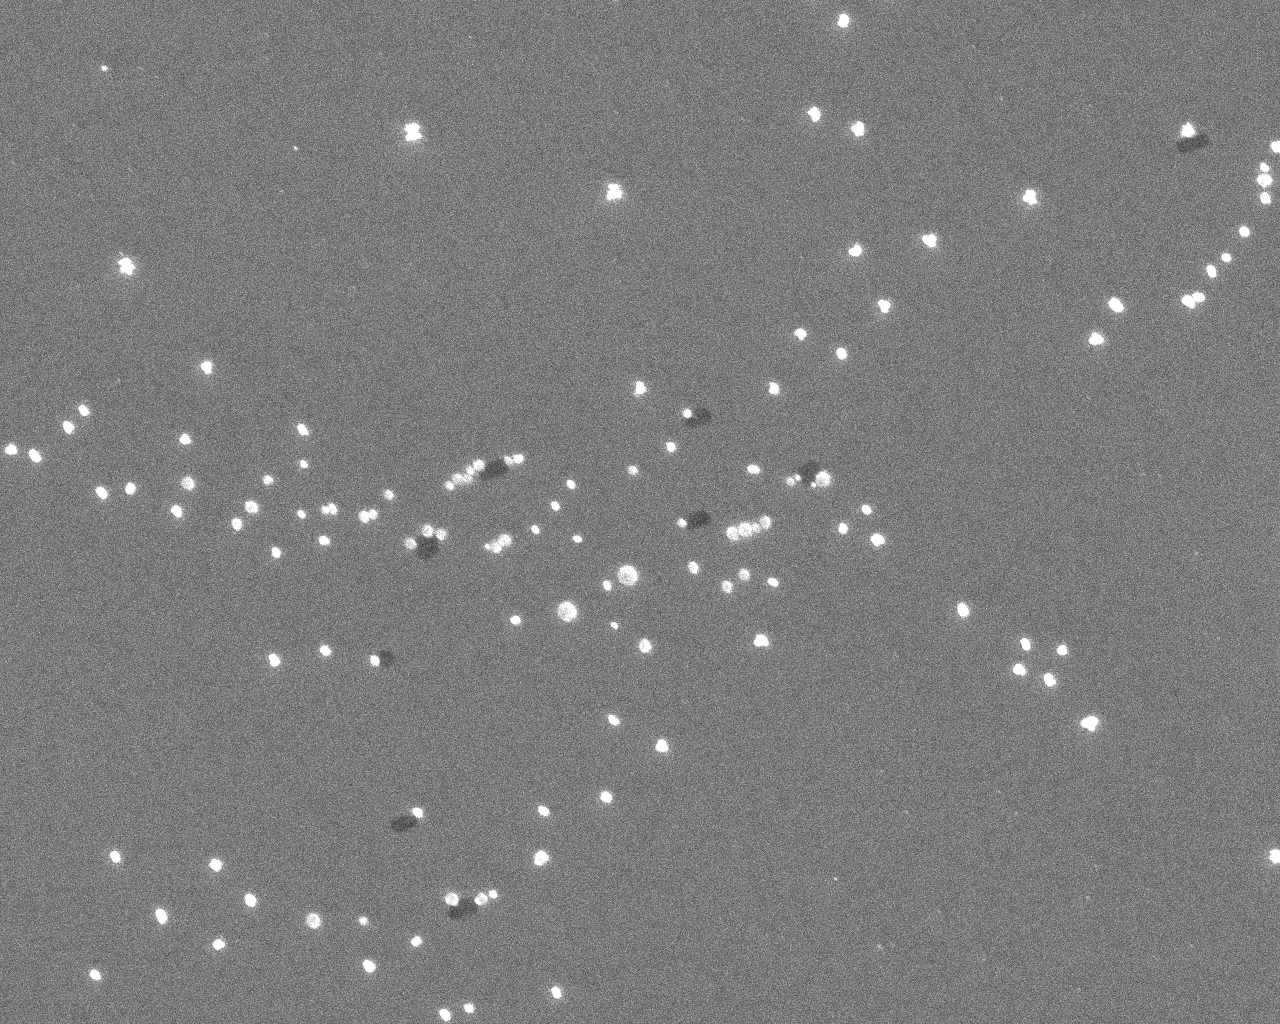

In [1]:
from glob import glob
from PIL import Image
im = Image.open(sorted(glob('./data/*.tif'))[0])
im

This is an SEM image!

In [ ]:
im = Image.open(sorted(glob('./data/*.png'))[0])
im

The light pixel has the value of 1 and dark pixel has the value of 0, indicating the whether there is a graphene.

## Homework part (a)
Instruction:\
Make a Dataset class to load the data.\
HINT: Have a look at HW13

In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import pandas as pd
import torch
from glob import glob
from torch.utils.data import DataLoader, random_split

class ImageData(Dataset):
    def __init__(self):
        X = []
        Y = []
        for p in glob('./data/*.tif'):
            im = Image.open(p)
            x = np.array(im)
            im = Image.open(p.replace('.tif','_mask.png'))
            y = np.array(im)
            X.append(x)
            Y.append(y)
        X = torch.Tensor(np.array(X))
        Y = torch.Tensor(np.array(Y))
        self.X = X[:,None,:,:]/255 # data_idx * C * H * W
        self.Y = Y[:,None,:,:]/255 # data_idx * C * H * W
        self.X = self.X.to('cuda') # if you want to use GPU, uncomment this
        self.Y = self.Y.to('cuda') # if you want to use GPU, uncomment this
        
    def __len__(self):
        ##################### Fill in here #####################
        number_of_data = self.X.shape[0]
        ##################### Fill in here #####################
        return number_of_data
        
    def __getitem__(self, idx):
        ##################### Fill in here #####################
        x = self.X[idx,:,:,:]
        y = self.Y[idx,:,:,:]
        ##################### Fill in here #####################
        return x,y
data = ImageData()

## Homework part (b)
Instruction:\
Randomly split your data into train, validation and test by 80, 10, and 10 percent.
HINT: Have a look at HW13

In [ ]:
data_train, data_val, data_test = random_split(data,[0.80,0.1,0.1])  ####### Fill in here #######

## Homework part (c)
Instruction:
Calculate the feature and output mean and standard deviation using the training set, and apply the normalization to all data set.


In [ ]:
X_train = []
Y_train = []
for x,y in data_train:
    X_train.append(x)
    Y_train.append(y)
X_train = torch.stack(X_train)
Y_train = torch.stack(Y_train)
##################### Fill in here #####################
Xmean = X_train.mean(0)
Xstd = X_train.std(0)
Ymean = Y_train.mean(0)
Ystd = Y_train.std(0)
##################### Fill in here #####################
data.X = (data.X-Xmean)/Xstd
data.Y = (data.Y-Ymean)/Ystd

## Homework part (d)
Instruction:\
Construct a CNN where the hidden layet has 16 channels

In [ ]:
import torch.nn as nn

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        ####### Fill in here #######
        self.L1 = torch.nn.Conv2d(1, 16, (5,5), padding=2)
        self.L2 = torch.nn.Conv2d(16, 1, (5,5), padding=2)
        self.act1 = nn.ReLU()
    def forward(self, X):
        ####### Fill in here #######
        Z1 = self.L1(X)
        A1 = self.act1(Z1)
        Z2 = self.L2(A1)
        return Z2
        
NN = Model()
NN = NN.to('cuda') # if you want to use GPU, uncomment this

The code below will train your model.

In [ ]:
dataloader_train = DataLoader(data_train, batch_size=128, shuffle=True)
dataloader_val = DataLoader(data_val, batch_size=128, shuffle=True)
dataloader_test = DataLoader(data_test, batch_size=128, shuffle=True)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(NN.parameters(),0.01, weight_decay = 0.01)
min_val_loss = torch.Tensor([float('Inf')])
train_loss_at_min_val_loss = torch.Tensor([float('Inf')])
min_val_loss = min_val_loss.to('cuda') # if you want to use GPU, uncomment this
for i in range(100): 
    train_loss = 0
    for X, Y in dataloader_train:
        yhat= NN(X)
        optimizer.zero_grad()
        loss = criterion(yhat,Y)
        loss.backward()
        train_loss += loss*Y.shape[0]
        optimizer.step()
    train_loss = train_loss/len(data_train)
    loss_val = 0
    for X, Y in dataloader_val:
        yhat = NN(X)
        loss_val += criterion(yhat,Y)*Y.shape[0]
    loss_val = loss_val/len(data_val)

    print(f'{i+1} epoch. train loss: {train_loss:.3f}, val loss: {loss_val:.3f}',end='')
    if loss_val < min_val_loss:
        torch.save(NN.state_dict(),'best.pth.tar')
        min_val_loss = loss_val
        train_loss_at_min_val_loss = train_loss
        print('<-new best',end='')
    print('')
print(f'Best model: train_loss {train_loss_at_min_val_loss:.3f} val_loss {min_val_loss:.3f}')

The code below is used for testing the model with test set.

In [ ]:
NN.load_state_dict(torch.load('best.pth.tar'))
YTest = []
YhatTest = []
for X, Y in dataloader_test:
    yhat = NN(X)
    YTest.append(Y)
    YhatTest.append(yhat)
YTest = torch.cat(YTest)
YhatTest = torch.cat(YhatTest)
print(f'Accuracy: {torch.mean((torch.round(torch.sigmoid(YhatTest))==YTest).double()):.3f}')